# **SemEval 2015 Task 12**

# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
!pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTR.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("./dataset")

     |████████████████████████████████| 4.9 MB 28.8 MB/s 
     |████████████████████████████████| 462 kB 19.2 MB/s 


In [ ]:
entities = ["FOOD","DRINKS","SERVICE","AMBIENCE","LOCATION","RESTAURANT"]   #6
attributes = ["GENERAL","PRICES","QUALITY","STYLE_OPTIONS","MISCELLANEOUS"] #5
polarities = ["negative","neutral","positive"]                              #3
vector_size = len(entities) * len(attributes)*len(polarities)

In [ ]:
def labels_encoding(opinions):
  label = list("0" * vector_size)
  for opinion in opinions:
        row_dict = opinion.attrib
        ent = row_dict["category"].split("#")[0]
        att = row_dict["category"].split("#")[1]
        pol = row_dict["polarity"]
        i = entities.index(ent)*len(attributes)*len(polarities) + attributes.index(att)*len(polarities)+polarities.index(pol)
        label[i]="1"
  label = "".join(label)
  # print(label)
  return label

In [ ]:
import numpy as np
xml_path = "/content/dataset/ABSA15_RestaurantsTrain/ABSA-15_Restaurants_Train_Final.xml"
mytree = ET.parse(xml_path)
reviews = mytree.getroot()
rows_list = []
for rew in reviews:
  rid = rew.attrib['rid']
  for sent in rew[0]: #cicle on single sentence in review.
    txt = sent[0].text
    if len(sent)>1:
      row_dict = {}
      row_dict['rid'] = rid
      row_dict['txt'] = txt
      row_dict['OOTS'] = False
      row_dict['label'] = labels_encoding(sent[1])
      rows_list.append(row_dict)
    else:
      rows_list.append({'rid':np.nan,'txt':txt,'OOTS':True})
df = pd.DataFrame(rows_list)
#target	category	polarity	from	to	rid	txt	entity	aspect

In [ ]:
df

In [ ]:
import spacy
nlp = spacy.load('en')

df.txt = df.txt.str.lower()

aspect_terms = []
for review in nlp.pipe(df.txt):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
df['aspect_terms'] = aspect_terms
df.head(10)

In [ ]:
df[["txt","aspect_terms"]].values[8]

## Data cleaning

In [ ]:
df['target'].value_counts()

In [ ]:
df[['entity', 'aspect']] = df['category'].str.split('#', 1, expand=True)
df = df.drop(['category'], axis=1)

In [ ]:
df['polarity'] = df['polarity'].map(lambda x: 0 if x == "negative" else 2 if x=="positive" else 1)

In [ ]:
df['to'].value_counts()

In [ ]:
# df['from'] = pd.to_numeric(df['from'])
# df['to'] = pd.to_numeric(df['to'])
df.info()

# Sentiment Analysis with BERT

## DatasetPreparation

In [ ]:
df=df[["txt","polarity"]]

In [ ]:
df.polarity.value_counts()

2    801
0    276
1    238
Name: polarity, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import tensorflow_text as text  # Registers the ops.

x_train, x_test, y_train, y_test = train_test_split(df['txt'],df['polarity'],stratify=df['polarity'])
# hot encoding of the polarity
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)
y_train.shape

(986, 3)

## Model Training

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")   #preprocessing layer str -> str for bert
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4") #encoding using bert str -> vector[]

In [ ]:
# Example of usage of the preprocessing+embedding.

def get_sentence_embedding(sentences):
  return bert_encoder(bert_preprocess(sentences))["pooled_output"]  #Pooled output is a vector of 7

get_sentence_embedding(["hello my name is"])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-8.35871339e-01, -3.40650618e-01, -2.67090619e-01,
         6.82823360e-01,  2.13039592e-01, -1.06711425e-01,
         8.32001746e-01,  1.36337265e-01, -9.60355848e-02,
        -9.99836385e-01,  3.19627970e-02,  8.03345680e-01,
         9.78835464e-01, -7.80729204e-02,  9.37619388e-01,
        -5.86379051e-01, -3.21323156e-01, -5.38785279e-01,
         2.89614350e-01, -3.08798492e-01,  5.79405069e-01,
         9.97939348e-01,  4.96504784e-01,  2.49937445e-01,
         3.22960526e-01,  9.18679774e-01, -7.09829390e-01,
         9.38315511e-01,  9.59785163e-01,  6.74820840e-01,
        -5.81379056e-01,  4.35466990e-02, -9.89920735e-01,
        -1.25694349e-01, -5.70317984e-01, -9.84190702e-01,
         2.30633348e-01, -6.82003319e-01,  1.30259572e-02,
         1.69475511e-01, -9.21833694e-01,  1.94067404e-01,
         9.99364734e-01, -4.97569025e-01,  3.42735827e-01,
        -3.20823431e-01, -9.99994278e-01,  1.76900268e-01,
      

In [ ]:
#Creation of the model
from tensorflow.keras import layers
import tensorflow as tf
input_txt = layers.Input(shape=(), dtype=tf.string, name="text")
preprocess_text = bert_preprocess(input_txt)
bert_encoder.trainable = False                                    #Freezed the weights of BERT.
encoded_text = bert_encoder(preprocess_text)

#Neural nel layers
l = layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
l = layers.Dense(64,activation="relu")(l)
l = layers.Dense(3,activation='softmax', name="output")(l)

#Generate the model
model = tf.keras.Model(inputs=[input_txt],outputs=[l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
batch_size = 8
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
METRICS = [
           tf.keras.metrics.CategoricalAccuracy(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=[x_test,y_test], callbacks=[callback])

Epoch 1/10
124/124 [==============================] - 24s 119ms/step - loss: 0.9788 - categorical_accuracy: 0.5994 - precision: 0.6171 - recall: 0.4544 - val_loss: 0.9325 - val_categorical_accuracy: 0.6079 - val_precision: 0.6130 - val_recall: 0.6018
Epoch 2/10
124/124 [==============================] - 14s 110ms/step - loss: 0.9302 - categorical_accuracy: 0.6095 - precision: 0.6376 - recall: 0.5122 - val_loss: 0.9247 - val_categorical_accuracy: 0.6079 - val_precision: 0.6436 - val_recall: 0.5380
Epoch 3/10
124/124 [==============================] - 14s 112ms/step - loss: 0.9171 - categorical_accuracy: 0.5984 - precision: 0.6494 - recall: 0.5091 - val_loss: 0.9154 - val_categorical_accuracy: 0.6109 - val_precision: 0.6705 - val_recall: 0.5258
Epoch 4/10
124/124 [==============================] - 14s 114ms/step - loss: 0.8779 - categorical_accuracy: 0.6166 - precision: 0.6671 - recall: 0.5385 - val_loss: 0.8965 - val_categorical_accuracy: 0.6079 - val_precision: 0.6311 - val_recall: 0.5

## Examples

In [ ]:
#Example
polarities = ["negative","neutral","positive"]
exml_sentence = "The service is not good."
out = model.predict([exml_sentence])
polarities[np.argmax(out)]

'positive'

In [ ]:
exml_sentence = "This food is very good."
out = model.predict([exml_sentence])
polarities[np.argmax(out)]

'positive'

In [ ]:
exml_sentence = "The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing."
out = model.predict([exml_sentence])
polarities[np.argmax(out)]

'positive'

In [ ]:
exml_sentence = "Delivery guy sometimes get upset if you don't tip more than 10%."
out = model.predict([exml_sentence])
polarities[np.argmax(out)] 

'negative'

In [ ]:
exml_sentence = "the pasta was good but the stake was bad."
out = model.predict([exml_sentence])
out 

array([[0.24271291, 0.1443338 , 0.61295325]], dtype=float32)

# Sentiment Analysis with PreTrainedModel

This a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5).

This model is intended for direct use as a sentiment analysis model for product reviews in any of the six languages above, or for further finetuning on related sentiment analysis tasks.
https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
pretrained_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
txt = ["I like you. I love you","i hate you."]

### Primo metodo

In [ ]:
inputs = bert_preprocess(txt)["input_word_ids"].numpy()
inputs = torch.tensor(inputs)
inputs
with torch.no_grad():
    logits = pretrained_model(inputs).logits
    predicted_class_id = logits.argmax().item()

In [ ]:
def get_stars(text):
  single_input = tokenizer(text, return_tensors="pt")
  with torch.no_grad():
      logits = pretrained_model(**single_input).logits
  return logits.numpy()

In [ ]:
print(single_input)

{'input_ids': tensor([[  101,   151, 11531, 10855,   119,   151, 11157, 10855,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
inputs

array([[ 101, 1045, 2066, 2017, 1012, 1045, 2293, 2017,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 101, 1045, 5223, 2017, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

In [ ]:
predicted_class_id = np.argmax(logits, axis=1).item()
predicted_class_id

ValueError: ignored

In [ ]:
arr = np.array(inputs['input_ids'])
arr = arr.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
torch.tensor(arr)

TypeError: ignored

### Secondo metodo

In [ ]:
inputs = tokenizer(txt)
inputs = inputs["input_ids"]
inputs

[[101, 151, 11531, 10855, 119, 151, 11157, 10855, 102],
 [101, 151, 39487, 10855, 119, 102]]

In [ ]:
def pad_text(texts, N):
  res = np.eye(len(texts),N)
  for i,t in enumerate(texts):
    t = np.append(t, [0] * (N - len(t)))
    res[i]=t
  return res

inputs = pad_text(inputs,512)
inputs = np.array(inputs)
inputs = inputs.astype(np.int32)

In [ ]:
inputs = inputs.astype(np.int32)

In [ ]:
inputs = torch.tensor(inputs)
token_type = [0]*512
mask = [1]*512

In [ ]:
mask = [mask]
token_type = [token_type]

In [ ]:
{'input_ids': tensor([[  101,   151, 11531, 10855,   119,   151, 11157, 10855,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


NameError: ignored

In [ ]:
dizionario = {'input_ids':inputs[0][None, :]}
dizionario['token_type_ids']=torch.tensor(token_type)
dizionario['attention_mask']=torch.tensor(mask)

In [ ]:
dizionario

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
with torch.no_grad():
    logits = pretrained_model(**dizionario).logits
    predicted_class_id = logits.argmax().item()

In [ ]:
logits

tensor([[ 0.3840,  0.6388,  0.4244, -0.0740, -0.9209]])

In [ ]:
predicted_class_id = logits[0].argmax().item()
predicted_class_id

1

In [ ]:
def adapt_tokenizer(words):
  shape = words.shape
  words = layers.Flatten(words)
  tokens = tokenizer(words)
  return np.array([tokens])

In [ ]:
## Creare un modello e aggiungerci preprocessing + questo modello.
from tensorflow.keras import layers
import tensorflow as tf
input_txt = layers.Input(shape=(), dtype=tf.string, name="text")
preprocess_text = tokenizer(input_txt)
with torch.no_grad():
    logits = model(**inputs).logits
    #Neural nel layers
l = layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
l = layers.Dense(3,activation='softmax', name="output")(l)

#Generate the model
model = tf.keras.Model(inputs=[input_txt],outputs=[l])
model.summary()

ValueError: ignored

In [ ]:
def method(nomi):
  return nomi

input_txt = layers.Input(shape=(512,), dtype=tf.string, name="text")
tokens = method(input_txt)
l = layers.Dense(3,activation="softmax",name="output")(tokens)

model2 = tf.keras.Model(inputs=[input_txt], outputs=[l])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 512)]             0         
                                                                 
 output (Dense)              (None, 3)                 1539      
                                                                 
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________


## Dataset augmentation

In [ ]:
def ds_augment(df,model):
  stelle = []
  for index, row in df.iterrows():
    single_input = tokenizer(row['txt'], return_tensors="pt")
    with torch.no_grad():
      logits = model(**single_input).logits
    stelle.append(logits)
  return stelle    

In [ ]:
stars = ds_augment(df,pretrained_model)

In [ ]:
stars

In [ ]:
star_new = list(map(lambda x: x[0].numpy(), stars))

In [ ]:
star_df = pd.DataFrame(data=star_new,columns=["1star","2star","3star","4star","5star"])

In [ ]:
df_new = pd.concat([df, star_df], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
x_train, x_test, y_train, y_test = train_test_split(df_new[['txt','1star','2star','3star','4star','5star']],df['polarity'],stratify=df['polarity'])
# hot encoding of the polarity
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)
y_train.shape

(986, 3)

In [ ]:
input_txt = layers.Input(shape=(), dtype=tf.string, name="text")
preprocess_text = bert_preprocess(input_txt)
bert_encoder.trainable=False                                    #Freezed the weights of BERT.
encoded_text = bert_encoder(preprocess_text)

input_stars = layers.Input(shape=(5),name="stars")

#Neural nel layers
l = layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
l = layers.Dense(64,activation="relu")(l)
l = layers.concatenate([input_stars, l])
l = layers.Dense(32, activation="relu")(l)
l = layers.Dense(3,activation='softmax', name="output")(l)

#Generate the model
model = tf.keras.Model(inputs=[input_txt,input_stars],outputs=[l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

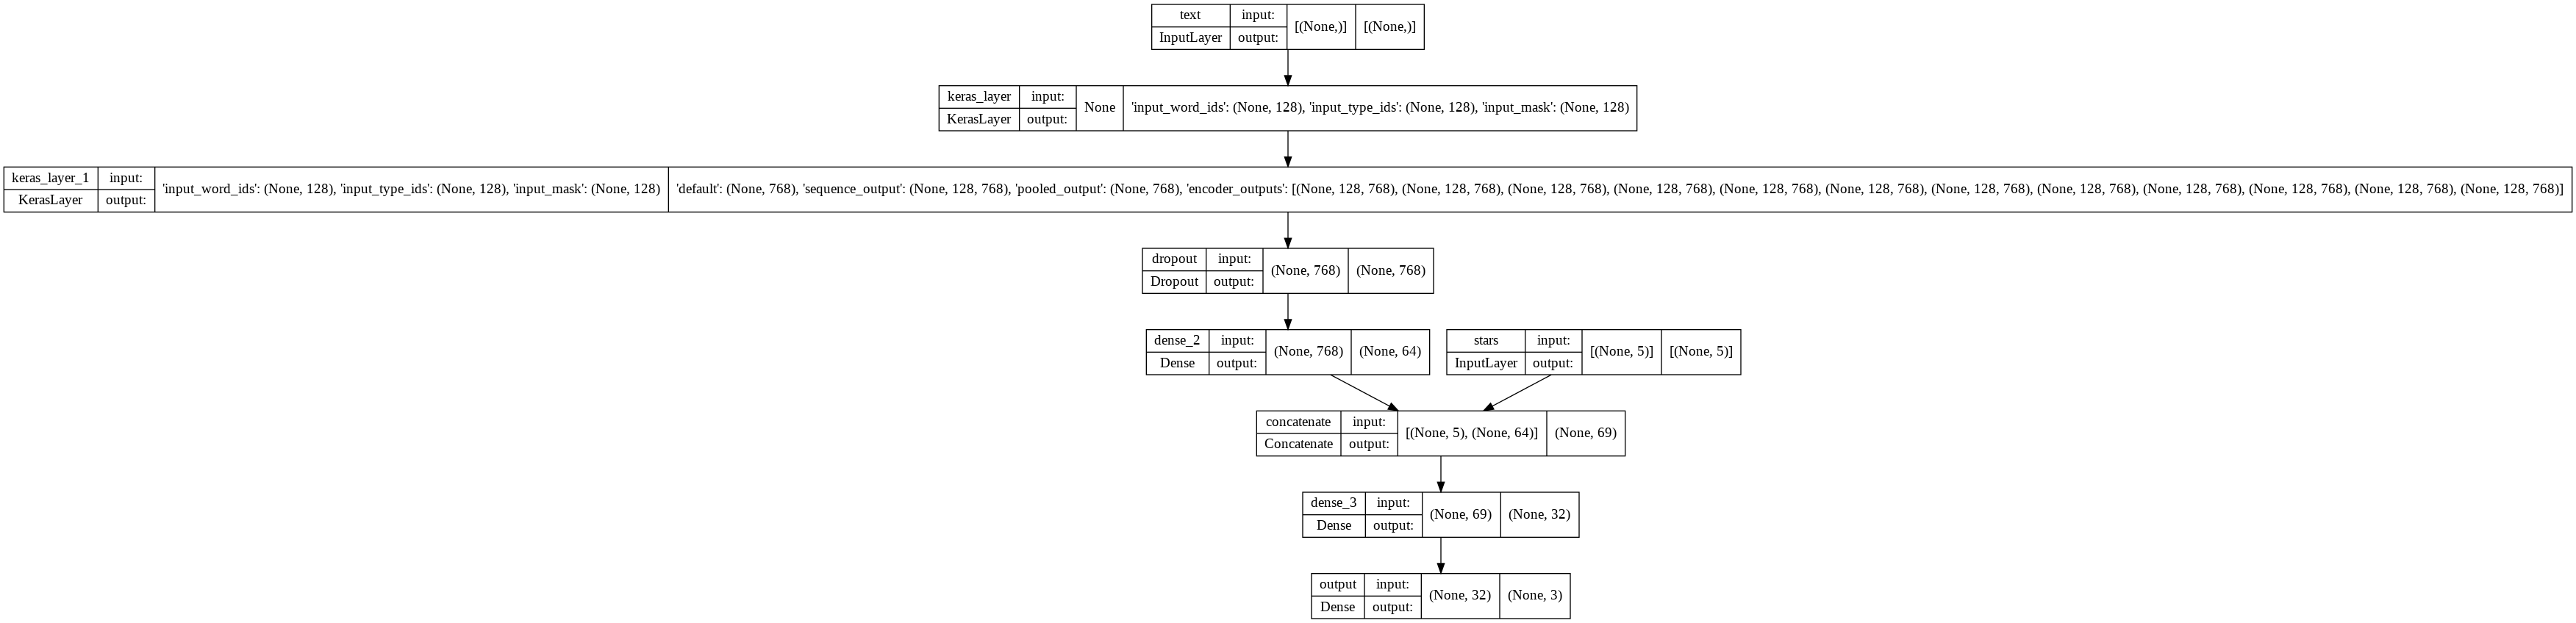

In [ ]:
import tensorflow
tensorflow.keras.utils.plot_model(model, "multi_input_model.png", show_shapes=True)

In [ ]:
# Save dataset.
# df_new.to_pickle("/content/drive/MyDrive/HLT/datasetwstars.pkl")  

In [ ]:
batch_size = 8
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
METRICS = [
           tf.keras.metrics.CategoricalAccuracy(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
model.fit([x_train['txt'],x_train[['1star','2star','3star','4star','5star']]], y_train, batch_size=batch_size, epochs=epochs, validation_data=[[x_test['txt'],x_test[['1star','2star','3star','4star','5star']]],y_test], callbacks=[callback])

Epoch 1/10
124/124 [==============================] - 47s 257ms/step - loss: 0.7363 - categorical_accuracy: 0.6937 - precision: 0.7506 - recall: 0.6288 - val_loss: 0.6785 - val_categorical_accuracy: 0.7264 - val_precision: 0.7635 - val_recall: 0.6869
Epoch 2/10
124/124 [==============================] - 31s 247ms/step - loss: 0.6782 - categorical_accuracy: 0.7221 - precision: 0.7793 - recall: 0.6481 - val_loss: 0.6849 - val_categorical_accuracy: 0.7204 - val_precision: 0.8000 - val_recall: 0.5957
Epoch 3/10
124/124 [==============================] - 30s 246ms/step - loss: 0.6782 - categorical_accuracy: 0.7181 - precision: 0.7743 - recall: 0.6471 - val_loss: 0.6372 - val_categorical_accuracy: 0.7112 - val_precision: 0.7885 - val_recall: 0.6687
Epoch 4/10
124/124 [==============================] - 33s 269ms/step - loss: 0.6650 - categorical_accuracy: 0.7211 - precision: 0.7778 - recall: 0.6389 - val_loss: 0.6675 - val_categorical_accuracy: 0.7143 - val_precision: 0.7595 - val_recall: 0.6

### Test

In [ ]:
testo = "the spaghetti were really good but the porc was not so good."
stars = get_stars(testo)[0]
stars

array([-1.141321  ,  0.92280924,  1.8750765 ,  0.7300526 , -2.0902185 ],
      dtype=float32)

In [ ]:
riga = pd.DataFrame([[testo]],columns=["text"])
riga = pd.concat([riga, pd.DataFrame([stars],columns=['1star','2star','3star','4star','5star'])], axis = 1)

In [ ]:
riga["1star"] = pd.to_numeric(riga["1star"])
riga["5star"] = pd.to_numeric(riga["5star"])
riga["4star"] = pd.to_numeric(riga["4star"])
riga["3star"] = pd.to_numeric(riga["3star"])
riga["2star"] = pd.to_numeric(riga["2star"])

In [ ]:
model.predict([riga['text'],riga[['1star','2star','3star','4star','5star']]])

array([[0.28716063, 0.27771416, 0.43512523]], dtype=float32)

In [ ]:
def get_stars(txt):
  single_input = tokenizer(txt, return_tensors="pt")
  with torch.no_grad():
    logits = pretrained_model(**single_input).logits
  return logits.numpy()

In [ ]:
def test_function(txt):
  stars = get_stars(txt)[0]
  riga = pd.DataFrame([[txt]],columns=["text"])
  riga = pd.concat([riga, pd.DataFrame([stars],columns=['1star','2star','3star','4star','5star'])], axis = 1)
  riga["1star"] = pd.to_numeric(riga["1star"])
  riga["5star"] = pd.to_numeric(riga["5star"])
  riga["4star"] = pd.to_numeric(riga["4star"])
  riga["3star"] = pd.to_numeric(riga["3star"])
  riga["2star"] = pd.to_numeric(riga["2star"])
  out = model.predict([riga['text'],riga[['1star','2star','3star','4star','5star']]])
  index = np.argmax(out)
  sentiments = ["bad","neutral","positive"]
  return "Sentiment: {} probability {}".format(sentiments[index],out[0][index])

In [ ]:
test_function("the pasta was really bad.")

'Sentiment: bad probability 0.8716690540313721'

In [ ]:
!pip install gradio
import gradio as gr
iface = gr.Interface(fn=test_function, inputs=["text"], outputs=["text"]).launch()

In [ ]:
# model.save("/content/drive/MyDrive/HLT/model.h5")

# Modelling

In [ ]:
!pip install transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")   #preprocessing layer str -> str for bert
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4") #encoding using bert str -> vector[]

In [ ]:
max_len = 384

def create_test_input_from_text(texts):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }
    for sentence in texts:
        input_ids = []
        for idx, word in enumerate(sentence.split()):
            ids = slow_tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids)
            num_tokens = len(ids)
            
        # Pad and create attention masks.
        # Skip if truncation is needed
        input_ids = input_ids[:max_len - 2]

        input_ids = [101] + input_ids + [102] # add starting and end tokens.
        n_tokens = len(input_ids)
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    return x, n_tokens

test_inputs = ["alex lives in london"]
x_test, n_tokens = create_test_input_from_text(test_inputs)
print('input tokens')
print(x_test[0][0][:n_tokens])
pred_test = model.predict(x_test)
pred_tags = np.argmax(pred_test,2)[0][:n_tokens]  # ignore predictions of padding tokens
print(pred_tags)

In [ ]:
txt = "ciao mi chiamo paolo"
f1 = slow_tokenizer.tokenize(txt)
f2 = slow_tokenizer.tokenize(txt)
fulty = f1+f2
indexed_tokens = slow_tokenizer.encode(text = txt, text_pair=txt)
indexed_tokens

In [ ]:
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"

encoded_dict = slow_tokenizer(sequence_a, sequence_b)
encoded_dict

In [ ]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

In [ ]:
res = encoder.predict([encoded_dict['input_ids'],encoded_dict['token_type_ids'],encoded_dict['attention_mask']])
res

In [ ]:
res[:,0,:]

In [ ]:
res[0][0].shape

In [ ]:
#Prova modello
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count
    
def build_model():
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )

    class_input = embedding['pooler_output']
    until_index = tf_count(token_type_ids, 0)-1
    ner_input = embedding[0][:,1:until_index,:]

    net = layers.Dense(64, activation='relu',name='class_layer1')(class_input)
    net = layers.Dropout(0.2)(net)
    net = layers.Dense(32, activation='relu',name='class_layer2')(net)
    net = layers.Dropout(0.2)(net)
    class_out = layers.Dense(2, activation='softmax',name='class_output')(net)

    embedding = layers.Dropout(0.3)(embedding[0])
    ner_out = layers.Dense(3, activation='softmax',name='ner_output')(ner_input)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[class_out,ner_out],
    )
    return model

prova = build_model()

In [ ]:
ner_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 17))
    loss_ = ner_loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

class_loss = tf.keras.losses.CategoricalCrossentropy()


lossWeights = [1.0, 1.0]
optimizer = keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=[class_loss, masked_ce_loss], metrics=['accuracy'], loss_weights=lossWeights)

In [ ]:
prova.summary()

In [ ]:
res = prova.predict(x_test)

In [ ]:
res[0].shape

In [ ]:
res[1].shape

In [ ]:
tf.keras.utils.plot_model(prova)

# Parte Nuova

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import os
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.0 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
!pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTR.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("./dataset")

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 462 kB 41.8 MB/s 


**Dataset creation**

In [ ]:
import numpy as np
xml_path = "/content/dataset/ABSA15_RestaurantsTrain/ABSA-15_Restaurants_Train_Final.xml"
mytree = ET.parse(xml_path)
reviews = mytree.getroot()
rows_list = []
for rew in reviews:
  rid = rew.attrib['rid']
  for sent in rew[0]: #cicle on single sentence in review.
    sid = sent.attrib['id']
    txt = sent[0].text
    if len(sent)>1:
      row_dict = {}
      row_dict['rid'] = rid # Review id
      row_dict['sid'] = sid # Sentence id
      row_dict['txt'] = txt
      row_dict['OOTS'] = False
      row_dict['f'] = 'yes'
      for opinion in sent[1]:
        op_dict = opinion.attrib
        rows_list.append({**row_dict,**op_dict})
    else:
      rows_list.append({'rid':rid,'sid':sid,'txt':txt,'OOTS':True,'target':np.nan,'category':np.nan,'polarity':np.nan,'from':0,'to':0,'f':'no'})
df = pd.DataFrame(rows_list)

In [ ]:
df['sid'].value_counts()

1726427:1    8
744478:1     7
490565:4     6
1126814:0    5
630914:2     5
            ..
1460715:4    1
1460715:5    1
1470286:1    1
1470334:0    1
958809:4     1
Name: sid, Length: 1315, dtype: int64

**Cartesian product of the categories+polarities**

In [ ]:
import itertools
categories = set(df[df['category'].notna()]['category'].values)
polarities = set(df[df['polarity'].notna()]['polarity'].values)
cat_pol_couples = set(list(itertools.product(categories,polarities)))
print(len(cat_pol_couples))

39


In [ ]:
cat_pol_couples

**Dataset augmentation with all possible combination of category and polarities different from the one with the values.**

In [ ]:
# Dataset augmentation with all possible combination of category and polarities different from the one with the values.
grouped_by_sid = df.groupby('sid').agg(list).reset_index()
new_rows = []
for index, row in grouped_by_sid.iterrows():
  cats = row['category']
  pols = row['polarity']
  current_list = set()
  if len(cats)>0 and (np.nan not in cats):
    for (i,c) in enumerate(cats):
      current_list.add((cats[i],pols[i]))
  for (newc,newpol) in cat_pol_couples.difference(current_list): # nuovi da aggiungere
    new_row = {'rid':row['rid'][0],'sid':row['sid'],'txt':row['txt'][0],'OOTS':'False','target':np.nan,'category':newc,'polarity':newpol,'from':0,'to':0,'f':'no'}
    new_rows.append(new_row)

In [ ]:
augmented_dataset_part = pd.DataFrame(new_rows)
df = pd.concat([df,augmented_dataset_part])
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,neutral,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#QUALITY,positive,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#MISCELLANEOUS,positive,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,AMBIENCE#GENERAL,negative,0,0


In [ ]:
df = df[df['category'].notna()] #this is needed because we already have inserted all the category combinatios also for no opinions reviews.
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,neutral,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#QUALITY,positive,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#MISCELLANEOUS,positive,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,AMBIENCE#GENERAL,negative,0,0


**Distribution of opinions over sentences**

In [ ]:
df['f'].value_counts()

no     49780
yes     1654
Name: f, dtype: int64

In [ ]:
df.groupby('sid').agg(len).reset_index()['category'].value_counts()

39    1205
40      84
41      18
42       5
43       2
45       1
Name: category, dtype: int64

**Special character identification**

In [ ]:
#special_caracters = [1012, 1010, 1029, 999, 1024] #in order .,?!:
special_caracters = ['.',',','?','!'] #in order .,?!:
intersection = lambda x: list(set.intersection(set(x),set(special_caracters)))
word = "this is a differentiator.,?!:"
print(slow_tokenizer.tokenize(word))
print(slow_tokenizer(word))

['this', 'is', 'a', 'different', '##ia', '##tor', '.', ',', '?', '!', ':']
{'input_ids': [101, 2023, 2003, 1037, 2367, 2401, 4263, 1012, 1010, 1029, 999, 1024, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
t="ao,"
len(t.replace("#",""))

3

**New algorithm for BIO tagging**

In [ ]:
import re
cleanString = lambda x: re.sub('\W+','',x)
list_of_tagging_list = []

for index, row in df.iterrows():
  tagging_list = []
  if row['f'] == 'yes':
    txt = row['txt'].split(' ')        # We split the sentence in words with ' ' spaces.
    targets = row['target'].split(' ') # Target:'food pasta pizza'.
    from_ = int(row['from'])
    to = int(row['to']) 
    position = 0
    old_tag = 'O'
    for w in txt:
      tokens = slow_tokenizer.tokenize(w) # We get the token for each word for istance: differentiator, -> ['different', '##ia', '##tor',',']
      for t in tokens: #for each token
        position+=len(t.replace("#",""))
        if position-len(t.replace("#",""))>=from_ and position<=to:
          if old_tag == 'O':
            tagging_list.extend(['B'])
          elif old_tag == 'B':
            tagging_list.extend(['I'])
          else:
            tagging_list.extend(['I'])
        else:
          tagging_list.extend(['O'])
      position+=1 #space
      old_tag = tagging_list[-1]
    token_all_phrase = slow_tokenizer.tokenize(row['txt'])
    # print("txt: {} targets:{} tokens:{} tagging: {} correct: {}".format(txt,targets,token_all_phrase,tagging_list,len(token_all_phrase)==len(tagging_list))) 
  else:
    len_tokens = len(slow_tokenizer.tokenize(row['txt'])) # tags all O
    tagging_list.extend(['O']*len_tokens)
      
  list_of_tagging_list.append(tagging_list)
df['tagging'] = list_of_tagging_list

In [ ]:
# Check if there are some opinions with Target but without any 'B' in the tagging.
tmp = df[df['target'].notna()]
tmp = tmp[tmp['target']!="NULL"]
sum=0
for i,row in tmp.iterrows():
  if 'B' in row['tagging']:
    sum+=1
  else:
    print("txt:{} tagging:{}".format(row["txt"],row['tagging']))
print(sum)

1279


**New column with category+polarity for the input.**

In [ ]:
#add the category column with the polarity.
list_aspects=[]
for i,row in df.iterrows():
  categ=None
  categ = (row["category"].lower()).split('#')
  new_text = categ[0]+" "+categ[1]+" "+row['polarity']
  list_aspects.append(new_text)
df['categ_txt'] = list_aspects
df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rid,sid,txt,OOTS,f,target,category,polarity,from,to,tagging,categ_txt
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56,"[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...",restaurant general negative
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general negative
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general negative
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",food quality negative
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O]",food style_options negative
...,...,...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,neutral,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general neutral
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#QUALITY,positive,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",drinks quality positive
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#MISCELLANEOUS,positive,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",restaurant miscellaneous positive
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,AMBIENCE#GENERAL,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",ambience general negative


In [ ]:
def merge_tagging(tags_list): # For each (text, category) the targets do not overlapp
  result = []
  if len(tags_list)==1:
    return tags_list[0]
  for i in range(len(tags_list[0])):
    for t in tags_list:
      val="O"
      if t[i] == "B" or t[i] == "I":
        val = t[i]
        break
      else:
        val = "O"
    result.append(val)
  return result

In [ ]:
tagging_frame = df.groupby(["txt", "categ_txt"]).agg(list).reset_index()[['txt','categ_txt','f','tagging']]
tagging_frame['tagging']= tagging_frame['tagging'].apply(lambda x: merge_tagging(x))
tagging_frame['f']= tagging_frame['f'].apply(lambda x: "yes" if "yes" in x else "no")
tagging_frame

,txt,categ_txt,f,tagging
0,$20 for all you can eat sushi cannot be beaten.,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,ambience general neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,$20 for all you can eat sushi cannot be beaten.,ambience general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,$20 for all you can eat sushi cannot be beaten.,drinks prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,$20 for all you can eat sushi cannot be beaten.,drinks prices neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
51202,wont come back again for sure!,restaurant prices neutral,no,"[O, O, O, O, O, O, O, O]"
51203,wont come back again for sure!,restaurant prices positive,no,"[O, O, O, O, O, O, O, O]"
51204,wont come back again for sure!,service general negative,no,"[O, O, O, O, O, O, O, O]"
51205,wont come back again for sure!,service general neutral,no,"[O, O, O, O, O, O, O, O]"


In [ ]:
tagging_frame[tagging_frame['txt']=="Good spreads, great beverage selections and bagels really tasty."]

In [ ]:
#Number of rows with a target in the tagging sequence.
sum=0
for i,row in tagging_frame.iterrows():
  if 'B' in row['tagging']:
    sum+=1
print(sum)

1137


In [ ]:
tagging_frame[tagging_frame['f']=="yes"]

,txt,categ_txt,f,tagging
17,$20 for all you can eat sushi cannot be beaten.,food prices positive,yes,"[O, O, O, B, I, I, I, I, I, O, O, O, O]"
56,"$6 and there is much tasty food, all of it fre...",food prices positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
59,"$6 and there is much tasty food, all of it fre...",food quality positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
62,"$6 and there is much tasty food, all of it fre...",food style_options positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
164,(Always ask the bartender for the SEASONAL bee...,drinks quality positive,yes,"[O, O, O, O, O, O, O, B, I, O, O, O]"
...,...,...,...,...
50994,too large for just two people but nothing was ...,food style_options negative,yes,"[O, O, O, O, O, O, O, O, O, O, O]"
51041,we love th pink pony.,restaurant general positive,yes,"[O, O, O, B, I, O]"
51117,"well, i didn't find it there, and trust, i hav...",restaurant general negative,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
51131,"whoever the jazz duo was, they were on POINT.",ambience general positive,yes,"[O, O, B, I, O, O, O, O, O, O, O]"


**Preparing dataset for the model**

In [ ]:
df = tagging_frame
df

,txt,categ_txt,f,tagging
0,$20 for all you can eat sushi cannot be beaten.,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,ambience general neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,$20 for all you can eat sushi cannot be beaten.,ambience general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,$20 for all you can eat sushi cannot be beaten.,drinks prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,$20 for all you can eat sushi cannot be beaten.,drinks prices neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
51202,wont come back again for sure!,restaurant prices neutral,no,"[O, O, O, O, O, O, O, O]"
51203,wont come back again for sure!,restaurant prices positive,no,"[O, O, O, O, O, O, O, O]"
51204,wont come back again for sure!,service general negative,no,"[O, O, O, O, O, O, O, O]"
51205,wont come back again for sure!,service general neutral,no,"[O, O, O, O, O, O, O, O]"


**Convering string values in integers**

In [ ]:
# convert yes,no in 0,1
# convert BIOP -> 0,1,2,3

**Dataset balancing**

In [ ]:
from sklearn.utils import shuffle
df_yes = df[df['f']=="yes"]
df_no = df[df['f']=="no"]
df_yes = shuffle(df_yes)
df_no = shuffle(df_no)
df_no = df_no.iloc[:1500]
df=pd.concat([df_yes,df_no])
df

,txt,categ_txt,f,tagging
24354,Not impressed with the food.,food quality negative,yes,"[O, O, O, O, B, O]"
22404,Mine was a little burnt but still delicious wi...,food quality negative,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
47049,"With so many good restaurants on the UWS, I do...",food prices negative,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9242,"Good, fast service.",service general positive,yes,"[O, O, O, B, O]"
13787,I have lived in Japan for 7 years and the tast...,food quality positive,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, ..."
...,...,...,...,...
9209,"Good, fast service.",drinks prices positive,no,"[O, O, O, O, O]"
17986,I've been many time and have never been disapp...,drinks quality neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O]"
43015,Was there Friday night.,service general neutral,no,"[O, O, O, O, O]"
36387,The service was excellent - friendly and atten...,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O]"


## Just Aspects

In [ ]:
!pip install -q tf-models-official

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from official.nlp import optimization

max_len = 256

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
# bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")   #preprocessing layer str -> str for bert


In [ ]:
#For loading hub layers from HUB in TPUs
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

In [ ]:
epochs = 2

def create_model():
    ## BERT encoder
    #encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,0]
    # ['pooler_output']
    embedding = layers.Dropout(0.1)(embedding)
    l = layers.Dense(32, activation="tanh")(embedding)
    # output = layers.Dense(1, activation='sigmoid')(l)
    output = layers.Dense(2, activation='softmax')(l)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output],
    )
    METRICS = [
              tf.keras.metrics.CategoricalAccuracy(),
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall()
    ]
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    steps_per_epoch = df.shape[0]
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    # model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

    return model

In [ ]:
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.summary()

In [ ]:
from sklearn.utils import shuffle

#Proviamo ad effettuare uno shaffling
df = shuffle(df)

In [ ]:
df.shape

In [ ]:
def create_ds():
  y = []
  val_y = []
  vl_size = 10
  num=0
  zeri=False
  input_ids= []
  token_type_ids= []
  attention_mask= []

  vl_input_ids= np.zeros((vl_size, max_len),dtype=np.dtype('i'))
  vl_token_type_ids= np.zeros((vl_size, max_len),dtype=np.dtype('i'))
  vl_attention_mask= np.zeros((vl_size, max_len),dtype=np.dtype('i'))

  for i,row in df.iterrows():
    dic = slow_tokenizer(row['txt'], text_pair=row['categ_txt'])
    dic['input_ids'].extend([0]*(max_len-len(dic['input_ids'])))
    dic['token_type_ids'].extend([1]*(max_len-len(dic['token_type_ids'])))
    dic['attention_mask'].extend([0]*(max_len-len(dic['attention_mask'])))
    f=1 if row['f']=='yes' else 0
    if num<5 and f==1 and zeri==False:
      vl_input_ids[num]=dic['input_ids']
      vl_token_type_ids[num]=dic['token_type_ids']
      vl_attention_mask[num]=dic['attention_mask']
      val_y.append(f)
      if len(val_y)==3:
        zeri=True
      num+=1
    elif num<vl_size and f==0 and zeri:
      vl_input_ids[num]=dic['input_ids']
      vl_token_type_ids[num]=dic['token_type_ids']
      vl_attention_mask[num]=dic['attention_mask']
      val_y.append(f)
      num+=1
    else:
      input_ids.append(dic['input_ids'])
      token_type_ids.append(dic['token_type_ids'])
      attention_mask.append(dic['attention_mask']) 
      y.append(f)
  x = [tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
    tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32)]
  return x, tf.convert_to_tensor(np.array(y), dtype=tf.dtypes.int32), [vl_input_ids,vl_token_type_ids,vl_attention_mask],tf.convert_to_tensor(np.array(val_y), dtype=tf.dtypes.int32)

In [ ]:
df['f'].value_counts().sort_values().plot(kind = 'barh')
df['f'].value_counts()

In [ ]:
x_train, y_train, val_x, val_y = create_ds()

In [ ]:
val_y

In [ ]:
y_train.shape

In [ ]:
bs=8
"""history = model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)"""
history = model.fit(x=x_train, y=y_train,
                    validation_data=(val_x, val_y), batch_size=bs,
                               epochs=epochs)

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
df[df['f']=='yes'].values[3]

In [ ]:
cat_pol_couples

In [ ]:
x = slow_tokenizer(text = "The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing.", text_pair="food quality positive")
# x = slow_tokenizer(text = "Told us to sit anywhere.", text_pair="service general negative")
x['input_ids'].extend([0]*(max_len-len(x['input_ids'])))
x['token_type_ids'].extend([1]*(max_len-len(x['token_type_ids'])))
x['attention_mask'].extend([0]*(max_len-len(x['attention_mask'])))
out = model([np.array([x['input_ids']]),np.array([x['token_type_ids']]),np.array([x['attention_mask']])])
out.numpy()

In [ ]:
out = model.predict(val_x)

In [ ]:
df.groupby('categ_txt')['f'].value_counts()

In [ ]:
df['categ_txt'].value_counts()

In [ ]:
out

In [ ]:
# df.to_csv("/content/drive/MyDrive/HLT/category_ds_balanced.csv")

### Test Sparse Categorical Cross Entropy

In [ ]:
input = layers.Input(shape=(11,), dtype=tf.int32)
l = layers.Dense(32,activation="relu")(input)
output = layers.Dense(2,activation="softmax")(l)
test_model = keras.Model(
        inputs=[input],
        outputs=[output],
    )
test_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics="accuracy")
test_model.summary()

In [ ]:
x_test = np.array([format(i, "b").zfill(11) for i in range(1000)])
y_test = np.array([i%2 for i in range(1000)])
x_test = np.array(list(map(lambda l: [int(d) for d in l],x_test)))
# y_test=to_categorical(y_test)

In [ ]:
test_model.fit(x=x_test,y=y_test, epochs=6, validation_split=0.2)

In [ ]:
#Inference
number=2043
snumber = format(number, "b").zfill(11)
print(snumber)
lnumber = np.array([[int(d) for d in snumber]])
test_model(lnumber)

## Just Entity recognition

In [ ]:
# slow_tokenizer("")
# cat_pol_couples
for c,p in cat_pol_couples:
  ctl=c.lower().split("#")
  q=ctl[0]+" "+ctl[1]+" "+p
  tokenized=slow_tokenizer.tokenize(q)
  print(len(tokenized))
#6 in the max number of tokens for the query.

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

max_len=266
query_len=10
max_len_txt=max_len-query_len
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)


def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,1:max_len_txt+1,:]
    embedding = layers.Dropout(0.3)(embedding)
    tag_logits = layers.Dense(num_tags, activation='softmax')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=[our_accuracy])
    return model

In [ ]:
def our_accuracy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.int32, name=None)
  y_pred = tf.cast(y_pred, tf.int32, name=None)
  mask = tf.math.logical_not(tf.math.equal(y_true, 3))
  total_no_padding = tf.reduce_sum(tf.cast(mask, tf.int32))
  mask = tf.cast(mask, dtype=tf.int32)
  # argmax_out = np.argmax(y_pred,-1)
  argmax_out = tf.math.argmax(
    y_pred,
    axis=-1,
    output_type=tf.dtypes.int32,
    name=None
  )
  print(y_true)
  print(mask)
  y_true *= mask
  argmax_out *= mask
  elements_equal_to_value = tf.equal(y_true, argmax_out)
  as_ints = tf.cast(elements_equal_to_value, tf.int32)
  count = tf.reduce_sum(as_ints)
  res = (count-(tf.size(y_true)-total_no_padding))/total_no_padding
  return res

In [ ]:
num_tags = 4 # BIOP
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(num_tags)
else:
    model = create_model(num_tags)
    
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.8.18.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.8.18.138:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 266)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_10[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
ex=("Not impressed with the food.","food quality negative")
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct
len(tokenize_couple(ex)['input_ids'])

266

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)          
  x = [
      tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags,dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
x_train, y_train = create_inputs_targets()

In [ ]:
y_train[0]

In [ ]:
bs = 64 if use_tpu else 16
# bs=8

model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.2
)

Tensor("Cast_10:0", shape=(None, 256), dtype=int32)
Tensor("Cast_13:0", shape=(None, 256), dtype=int32)


Tensor("Cast_10:0", shape=(None, 256), dtype=int32)
Tensor("Cast_13:0", shape=(None, 256), dtype=int32)
38/38 [==============================] - ETA: 0s - loss: nan - our_accuracy: nan      Tensor("Cast_10:0", shape=(None, 256), dtype=int32)
Tensor("Cast_13:0", shape=(None, 256), dtype=int32)
38/38 [==============================] - 167s 2s/step - loss: nan - our_accuracy: nan - val_loss: nan - val_our_accuracy: nan


In [ ]:
print(df.values[1])
tokens = slow_tokenizer(df.values[0][2], max_length=max_len, padding='max_length')
tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,df.values[0][-1]))+[0]
tagging.extend([3]*(max_len-len(tagging)))
print("{} \n {}".format(tokens,tagging))

In [ ]:
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = model.predict(x)
out = np.array(out)
out.shape
out[0][:]

In [ ]:
np.array(out).shape

In [ ]:
tagging

In [ ]:
out.shape

In [ ]:
len(argmax_out)

In [ ]:
tagging = [tagging,tagging]

In [ ]:
tagging

In [ ]:
real_seq_len

In [ ]:
argmax_out = [argmax_out[0],argmax_out[0]]

In [ ]:
argmax_out

In [ ]:
argmax_out

In [ ]:
out = [out[0], out[0]]
np.array(out).shape

In [ ]:
np.array(out).shape

In [ ]:
argmax_out = np.argmax(out,-1)
argmax_out

In [ ]:
tagging

In [ ]:
print()

In [ ]:
mask = tf.math.logical_not(tf.math.equal(tagging, 3))
total_no_padding = tf.reduce_sum(tf.cast(mask, tf.int32)).numpy()
mask = tf.cast(mask, dtype=tf.int8)
argmax_out = np.argmax(out,-1)
tagging *= mask
argmax_out *= mask
elements_equal_to_value = tf.equal(tagging, argmax_out)
as_ints = tf.cast(elements_equal_to_value, tf.int32)
count = tf.reduce_sum(as_ints)
res = (count-(tf.size(tagging)-total_no_padding))/total_no_padding
res

In [ ]:
out
mask = tf.math.logical_not(tf.math.equal(tagging, 3))
mask = tf.cast(mask, dtype=loss_.dtype)
loss_ *= mask

In [ ]:
loss_